# 巴西电商用户分析：留存与简版LTV预测 / Brazilian E‑commerce User Analysis: Cohort Retention & Simplified LTV Prediction

## 0. 环境与数据 / Environment and Data

### 0.1 说明 / Description

本 Notebook 在 Kaggle 平台运行。
- Notebook 链接：[https://www.kaggle.com/code/yiquanxiao/brazilian-e-commerce-user-analysis-cohort-retenti](https://www.kaggle.com/code/yiquanxiao/brazilian-e-commerce-user-analysis-cohort-retenti)

---

This notebook runs on the Kaggle platform.
- Notebook Link: [https://www.kaggle.com/code/yiquanxiao/brazilian-e-commerce-user-analysis-cohort-retenti](https://www.kaggle.com/code/yiquanxiao/brazilian-e-commerce-user-analysis-cohort-retenti)

前作（用户分群）：[https://www.kaggle.com/code/yiquanxiao/brazilian-e-commerce-customer-segmentation](https://www.kaggle.com/code/yiquanxiao/brazilian-e-commerce-customer-segmentation)

---

Previous Work (Customer Segmentation): [https://www.kaggle.com/code/yiquanxiao/brazilian-e-commerce-customer-segmentation](https://www.kaggle.com/code/yiquanxiao/brazilian-e-commerce-customer-segmentation)

### 0.2 依赖 / Dependencies

In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

## 1. 数据与模型加载 / Data & Model Loading

### 1.1 加载原始 CSV 数据 / Load CSV files

In [2]:
data_path = Path('/kaggle/input/brazilian-ecommerce')
# 客户基本信息 / Customer info
customers = pd.read_csv(data_path / 'olist_customers_dataset.csv')
# 订单明细（含购买时间）/ Orders (with purchase timestamp)
orders = pd.read_csv(data_path / 'olist_orders_dataset.csv')
# 支付记录（含支付金额）/ Payments (with payment value)
payments = pd.read_csv(data_path / 'olist_order_payments_dataset.csv')
# 额外加载 order_items & products，用于品类特征 / Load for product category
order_items = pd.read_csv(data_path / 'olist_order_items_dataset.csv')
products = pd.read_csv(data_path / 'olist_products_dataset.csv')

### 1.2 加载预训练对象（scaler.pkl, kmeans_model.pkl）/ Load scaler & K‑Means model

Here, we use the pretrained scaler and KMeans model from previous work.

In [3]:
models_path  = Path('/kaggle/input/brazilian-e-commerce-customer-segmentation')
scaler = joblib.load(models_path / 'scaler.pkl')
kmeans_model = joblib.load(models_path / 'kmeans_model.pkl')

## 2. 数据预处理 / Data Preprocessing  

### 2.1 数据清洗 / Data Cleaning

In [4]:
# 检查缺失值及重复 / Check missing values and duplicates
for df_name, df in [("customers", customers), 
                    ("orders", orders), 
                    ("payments", payments), 
                    ("order_items", order_items), 
                    ("products", products)]:
    print(f"Checking {df_name} ...")
    print(f"# of duplicates: {df.duplicated().sum()}")
    # print(f"# of duplicates: {df[key].duplicated().sum()}")
    print(f"# of missing items:")
    print(df.isnull().sum())
    print("--------------------------------------------")

Checking customers ...
# of duplicates: 0
# of missing items:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
--------------------------------------------
Checking orders ...
# of duplicates: 0
# of missing items:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
--------------------------------------------
Checking payments ...
# of duplicates: 0
# of missing items:
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64
--------------------------------------------
Checking order_items ...
# of duplicates: 0
# of missing ite

没有重复值，出现了一些缺失值。但是对于我们关注的那几列来说，只有`product_category_name`有重复的情况。所以只需要处理这个就好了。

There are no duplicate values, but some missing values have appeared. However, for the columns we're focusing on, only `product_category_name` has duplicates. So we only need to handle that.

In [5]:
# 处理缺失值 / Handling missing value
products['product_category_name'] = products['product_category_name'].fillna("unknown")

In [6]:
# 只保留必要字段 / Select only required columns
customers = customers[['customer_id', 'customer_unique_id', 'customer_state']]
orders = orders[['order_id', 'customer_id', 'order_purchase_timestamp']]
payments = payments[['order_id', 'payment_value', 'payment_type']]
order_items = order_items[['order_id', 'product_id']]
products = products[['product_id', 'product_category_name']]

for df in [customers, orders, payments, order_items, products]: 
    print(df.info())
    print("-----------------------------------------------------------------")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         99441 non-null  object
 1   customer_unique_id  99441 non-null  object
 2   customer_state      99441 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB
None
-----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   order_id                  99441 non-null  object
 1   customer_id               99441 non-null  object
 2   order_purchase_timestamp  99441 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB
None
-----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10

In [7]:
# 转换订单的时间列为 datetime / Convert order timestamp columns to datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

### 2.2 合并核心表格 / Merge core tables

In [8]:
# 合并 orders 与 payments / Merge orders & payments
orders_payments = orders.merge(payments, on='order_id', how='left')

# 合并 customers 获取 unique_id 和地区 / Merge customers for unique_id & state
orders_payments = orders_payments.merge(
    customers, on='customer_id', how='left'
)

# 合并 order_items 与 products，后续可聚合品类特征 / Merge order_items & products for category
order_items_products = order_items.merge(
    products, on='product_id', how='left'
)

In [9]:
# 检查 merge 后可能出现的缺失值 / Check possible missing values after merge
print(orders_payments.isnull().sum())
print("----------------------------------")
print(order_items_products.isnull().sum())

order_id                    0
customer_id                 0
order_purchase_timestamp    0
payment_value               1
payment_type                1
customer_unique_id          0
customer_state              0
dtype: int64
----------------------------------
order_id                 0
product_id               0
product_category_name    0
dtype: int64


可以看到 merge 之后存在缺失值的情况。这里，我们打算用下面的策略来填补：

- 对于 `payment_type`：将缺失值填补为 `"unknown"`，表示该订单缺少支付方式信息；
- 对于 `payment_value`：我们使用对应 `customer_state` 的中位数进行填补，假设不同地区用户的支付金额存在结构性差异。

---

We observe that there are missing values after merging the tables. To address this, we apply the following imputation strategies:

- For `payment_type`: Missing values are filled with `"unknown"` to indicate that no payment method was recorded for the order;
- For `payment_value`: Missing values are imputed using the median payment value for the corresponding `customer_state`, assuming regional differences in customer payment behavior.

In [10]:
# 计算每个 customer_state 对应的 payment_value 中位数
# Compute median payment_value per customer_state
state_medians = (
    orders_payments
    .groupby('customer_state')['payment_value']
    .median()
)

# 定义填补函数
# Define imputation function based only on customer_state
def fill_by_state(row):
    if pd.notnull(row['payment_value']):
        return row['payment_value']
    
    state = row['customer_state']
    
    # 如果 state 存在中位数，填入；否则使用全局中位数或 0
    if state in state_medians.index:
        return state_medians.loc[state]
    return orders_payments['payment_value'].median()  # or return 0

In [11]:
# 处理缺失值 / Handling missing value
orders_payments['payment_type'] = orders_payments['payment_type'].fillna("unknown")
orders_payments['payment_value'] = orders_payments.apply(fill_by_state, axis=1)
print(orders_payments.isnull().sum())

order_id                    0
customer_id                 0
order_purchase_timestamp    0
payment_value               0
payment_type                0
customer_unique_id          0
customer_state              0
dtype: int64


### 2.3 生成 RFM 特征 / Prepare RFM features

In [12]:
# 计算基准日期 / Reference date = last purchase timestamp
reference_date = orders_payments['order_purchase_timestamp'].max()

# 按用户计算 R、F、M / Compute Recency, Frequency, Monetary
rfm = (
    orders_payments
    .groupby('customer_unique_id')
    .agg(
        R = ('order_purchase_timestamp', lambda x: (reference_date - x.max()).days),
        F = ('order_id', 'nunique'),
        M = ('payment_value', 'sum')
    )
    .reset_index()
)

rfm.head()

,customer_unique_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19
2,0000f46a3911fa3c0805444483337064,585,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,336,1,196.89


### 2.4 应用 Scaler + 生成 K‑Means 簇标签 / Apply scaler & assign clusters

In [13]:
# 标准化 RFM 特征 / Scale RFM features
rfm_raw = rfm.copy()
rfm[['R_z', 'F_z', 'M_z']] = scaler.transform(rfm[['R', 'F', 'M']])

# 预测簇标签并合并回 rfm / Predict cluster labels and merge back
rfm['cluster'] = kmeans_model.predict(rfm[['R_z', 'F_z', 'M_z']])
rfm.head()

,customer_unique_id,R,F,M,R_z,F_z,M_z,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,-0.832621,-0.162368,-0.106697,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,-0.813067,-0.162368,-0.602360,1
2,0000f46a3911fa3c0805444483337064,585,1,86.22,1.937662,-0.162368,-0.347291,0
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,0.529706,-0.162368,-0.531366,0
4,0004aac84e0df4da2b147fca70cf8255,336,1,196.89,0.314602,-0.162368,0.130916,0


## 3. Cohort 留存分析 / Cohort Retention Analysis

### 3.1 定义 Cohort（首购月份） / Define cohorts by first purchase month

In [14]:
order_counts = orders_payments.groupby('customer_unique_id')['order_id'].nunique()
# 筛选出重复购买的用户（订单数 > 1）
repeat_buyers = order_counts[order_counts > 1]
# 统计重复购买用户数量
num_repeat_buyers = repeat_buyers.shape[0]
# 重复购买率
total_users = order_counts.shape[0]
repeat_rate = num_repeat_buyers / total_users
print(f'重复购买率: {repeat_rate:.2%}')

重复购买率: 3.12%


In [15]:
# 创建订单月份字段 / extract order month
orders_payments['order_month'] = orders_payments['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()
# 用户首购月份 / cohort month per user
cohort_df = (
    orders_payments
    .groupby('customer_unique_id')['order_month']
    .min()
    .reset_index()
    .rename(columns={'order_month': 'cohort_month'})
)
# 合并 cohort_month / merge back
orders_payments = orders_payments.merge(cohort_df, on='customer_unique_id', how='left')

### 3.2 计算每期留存率 / Calculate retention rates

In [16]:
# 计算用户在每个订单的“期数” / period number since cohort
orders_payments['period_number'] = (
    (orders_payments['order_month'].dt.year - orders_payments['cohort_month'].dt.year) * 12 +
    (orders_payments['order_month'].dt.month - orders_payments['cohort_month'].dt.month)
)

# 去重：每用户每期只算一次 / drop duplicate user-period
user_period = orders_payments.drop_duplicates(
    ['customer_unique_id', 'cohort_month', 'period_number']
)

# 引入簇标签 / attach cluster
user_period = user_period.merge(
    rfm[['customer_unique_id', 'cluster']],
    on='customer_unique_id', how='left'
)

# 计算基期用户数 / number of users in period 0 for each cohort & cluster
cohort_sizes = (
    user_period[user_period['period_number'] == 0]
    .groupby(['cohort_month', 'cluster'])['customer_unique_id']
    .nunique()
    .reset_index(name='n_users')
)

# 计算每期活跃用户数 / active users per period
retention_counts = (
    user_period
    .groupby(['cohort_month', 'cluster', 'period_number'])['customer_unique_id']
    .nunique()
    .reset_index(name='active_users')
)

# 合并并计算留存率 / merge and compute retention rate
retention = retention_counts.merge(
    cohort_sizes, on=['cohort_month', 'cluster']
)
retention['retention_rate'] = retention['active_users'] / retention['n_users']

In [17]:
retention.head()

,cohort_month,cluster,period_number,active_users,n_users,retention_rate
0,2016-09-01,0,0,4,4,1.000000
1,2016-10-01,0,0,302,302,1.000000
2,2016-10-01,2,0,12,12,1.000000
3,2016-10-01,2,6,1,12,0.083333
4,2016-10-01,2,9,1,12,0.083333


### 3.3 按 K‑Means 簇拆分留存对比 / Compare retention by cluster

In [18]:
# 过滤期数（ 0–12月 ） / limit to first year
retention = retention[retention['period_number'] <= 12]

### 3.4 可视化留存热力图 / Visualize retention heatmap

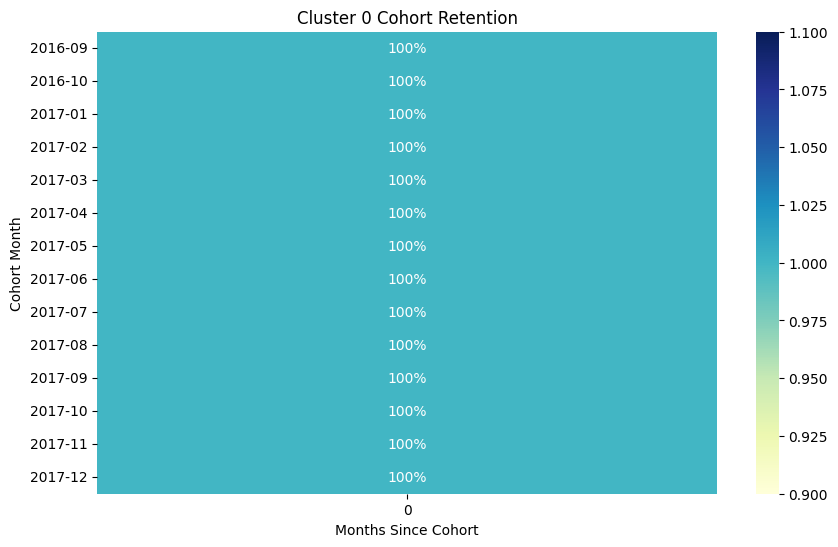

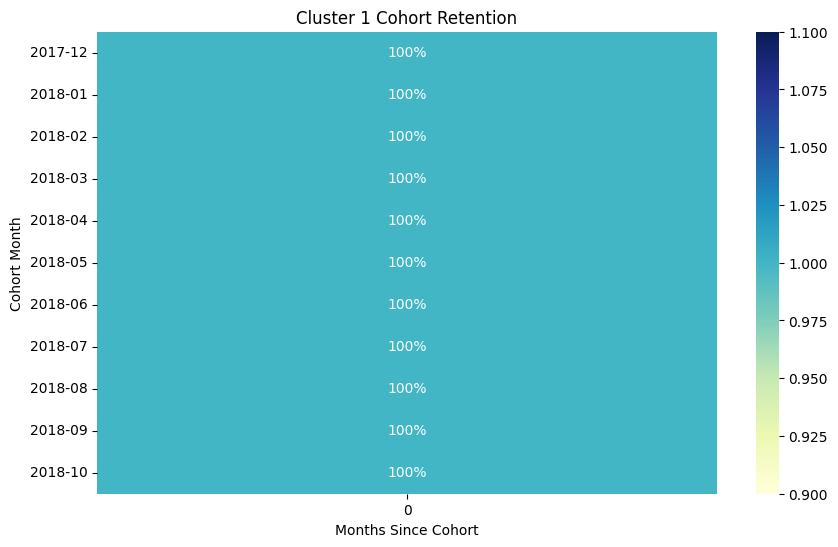

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


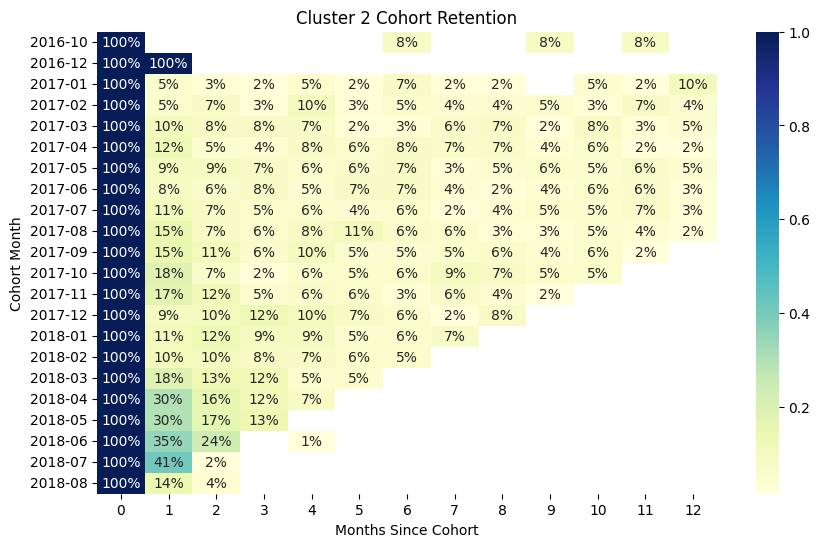

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


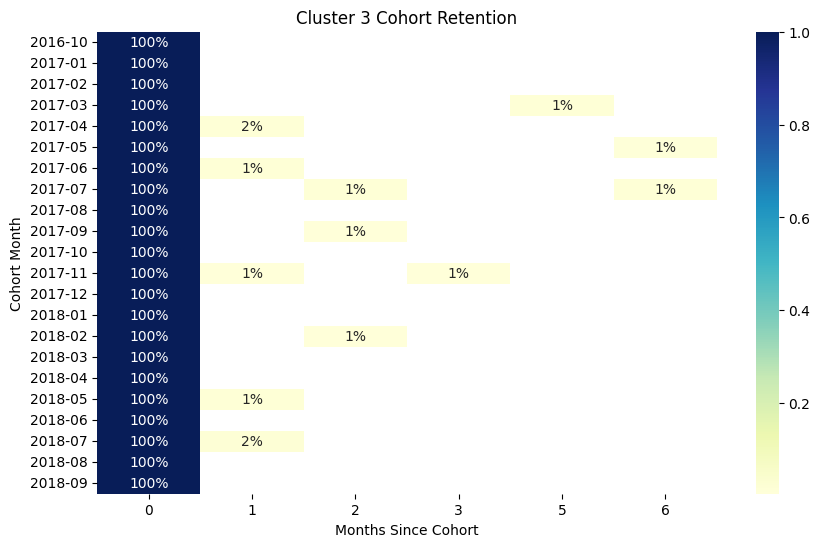

In [19]:
# 为每个 cluster 绘制热力图 / loop clusters
for cl in sorted(retention['cluster'].unique()):
    sub = retention[retention['cluster'] == cl].copy()
    sub['cohort_month'] = sub['cohort_month'].dt.to_period('M').astype(str)
    pivot = sub.pivot(index='cohort_month', columns='period_number', values='retention_rate')
    # pivot = pivot.fillna(0)
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".0%", cmap='YlGnBu', mask=pivot.isnull())
    plt.title(f'Cluster {cl} Cohort Retention')
    plt.ylabel('Cohort Month')
    plt.xlabel('Months Since Cohort')
    plt.show()

In [20]:
# 为每个簇计算每期的平均留存率 / Calculate average retention rate per period for each cluster
for cl in sorted(retention['cluster'].unique()):
    sub = retention[retention['cluster'] == cl].copy()
    sub['cohort_month'] = sub['cohort_month'].dt.to_period('M').astype(str)
    avg_retention_rate = (
        sub.groupby(['period_number'])['retention_rate'].mean().reset_index(name="avg_retention_rate")
    )
    print(f"Cluster {cl}:")
    print(avg_retention_rate)
    print("========================================")

Cluster 0:
   period_number  avg_retention_rate
0              0                 1.0
Cluster 1:
   period_number  avg_retention_rate
0              0                 1.0
Cluster 2:
    period_number  avg_retention_rate
0               0            1.000000
1               1            0.201917
2               2            0.094717
3               3            0.071690
4               4            0.067504
5               5            0.053421
6               6            0.059035
7               7            0.049019
8               8            0.049072
9               9            0.043716
10             10            0.052900
11             11            0.046611
12             12            0.041562
Cluster 3:
   period_number  avg_retention_rate
0              0            1.000000
1              1            0.013365
2              2            0.010064
3              3            0.005128
4              5            0.014085
5              6            0.013487


### 洞察 / Insights

**簇 0 留存洞察：**

- **留存表现 / Retention Behavior**  
  - 期数 0（首月）留存 100%，之后所有期数复购率几乎为 0  
  - 首购后即彻底流失，无二次行动迹象  

- **画像回顾 / Profile Recap**  
  - R ≈ 438 天：最后一次购买时间非常久远  
  - F = 1 笔：仅发生过一次交易  
  - M ≈ 135 元：低客单价  

- **运营建议 / Actionable Recommendations**  
  1. **深度“回流”优惠**：用户已流失一年以上，直接用“重回有礼”超大幅度折扣（如 $50\%$ + 包邮）刺激一次性回购
  2. **品牌唤醒广告**：在微信/社交媒体投放品牌回访广告，重新激发认知  
  3. **流失原因调研**：发放“流失调查”问卷，小规模采样获取用户痛点，为后续改版提供依据  

---

**簇 1 留存洞察：**

- **留存表现 / Retention Behavior**  
  - 期数 0 留存 100%，之后基本无复购，与簇 0 保持一致  
  - 不过首购距今仅 ~177 天，品牌记忆尚未完全消退  

- **画像回顾 / Profile Recap**  
  - R ≈ 177 天：最近一次购买约半年之前  
  - F = 1 笔：仅有单次消费  
  - M ≈ 135 元：低客单价  

- **运营建议 / Actionable Recommendations**  
  1. **“半年关怀”专属触达**：在第 180 天节点推送“周年回馈”优惠券（如 15% OFF／满减券），抓住品牌还留存印象的窗口
  2. **个性化召回**：根据用户首次购买品类，推荐相似或补充产品，利用 短信/推送通知 精准触达  
  3. **免邮/小额优惠**：赠送一次“免邮券”或“小额返现券”（如满 100 元返 10 元），降低用户回购门槛

---

**簇 2 留存洞察：**

- **留存表现**  
  - 第 1 期（月）平均留存 ~20.2%：约五分之一的用户在首月复购  
  - 第 2 期（月）~9.5%，第 3 期 ~7.2%，第 4 期 ~6.8%：复购率迅速回落至中下水平  
  - 第 5–6 期维持在 ~5–6%：形成稳定的中期复购 “中坚” 群体  
  - 第 7–12 期长尾留存 ~4–5%：少量高粘性用户持续贡献价值  

- **画像回顾**  
  - R ≈ 268 天：用户距离最后一次购买较长  
  - F ≈ 2.1 笔：平均发生 2 次以上交易  
  - M ≈ 290 元：中等消费水平  

- **运营建议**  
  1. **首月深度运营**：第 1 期后留存率最大（20%），可在 0–30 天内推「组合优惠包」或「满减券」，提升第 2 次交易意愿  
  2. **中期粘性培养**：第 2–4 期（6–12 周）进行积分激励或小额专属折扣，稳固中期活跃用户  
  3. **长尾价值挖掘**：对第 5 期后依旧活跃的 ~5% 用户，重点推荐新品或 VIP 专属权益，激励其成为品牌忠实用户  
  4. **差异化测试**：基于地域或品类偏好，A/B 测试不同优惠形式（满减 vs. 捆绑）和渠道（App 推送 vs. EDM），找到对复购影响最大的方案  

---

**簇 3 留存洞察：**

- **留存表现 / Retention Behavior**  
  - 第 1 期（月）留存 ~1.34%、第 2 期 ~1.01%、第 3 期 ~0.51%：首月之后几乎不复购  
  - 第 5–6 期小幅回升至 ~1.35–1.41%：少数用户在中长期出现二次高额购买  

- **画像回顾 / Profile Recap**  
  - R ≈ 288 天：较久未复购，但并非完全流失  
  - F = 1 笔：以单次高额消费为主  
  - M ≈ 1,196 元：一次性大额客单  

- **运营建议 / Actionable Recommendations**  
  1. **高端定制关怀**：在第 4–5 月节点推送专属 VIP 权益（如新品预览、免费配送），利用二次购高价值用户的平均复购时机  
  2. **个性化推荐**：基于首单品类和所处地区，精准推送相似或升级款产品  
  3. **会员/礼遇升级**：对 Cluster 3 用户开放限时邀请制会员或积分加速通道，强化品牌黏性  
  4. **高触达渠道**：电话/微信专属客服或一对一邮件，提高高净值用户的专属感与二次购买意愿  


## 4. 简版 LTV 预测 / Simplified LTV Prediction  

### 4.1 划分时间窗口 & 基于 cutoff_date 计算特征 / Split by cutoff_date & compute features

In [21]:
# 1) 定义时间窗口 / Define time window
max_date = orders_payments['order_purchase_timestamp'].max()
cutoff_date = max_date - DateOffset(months=6)
label_end = cutoff_date + DateOffset(months=6)

# 2) 划分数据集 / Split dataset
train_orders  = orders_payments[orders_payments['order_purchase_timestamp'] <= cutoff_date]
future_orders = orders_payments[
    (orders_payments['order_purchase_timestamp'] > cutoff_date) &
    (orders_payments['order_purchase_timestamp'] <= label_end)
]

# 3) 基于 train_orders 计算 RFM / Compute RFM features on train_orders
reference_date = cutoff_date
rfm_train = (
    train_orders
    .groupby('customer_unique_id')
    .agg(
        R = ('order_purchase_timestamp', lambda x: (reference_date - x.max()).days),
        F = ('order_id', 'nunique'),
        M = ('payment_value', 'sum')
    )
    .reset_index()
)

# 4) 标准化 & 聚类标签 / Scale & cluster label
rfm_train[['R_z', 'F_z', 'M_z']] = scaler.transform(rfm_train[['R','F','M']])
rfm_train['cluster'] = kmeans_model.predict(rfm_train[['R_z','F_z','M_z']])

# 5) 基于 train_orders 计算其他特征 / Compute other features on train_orders
# 计算品类多样度 / Compute category diversity per user
order_items_train = order_items_products.merge(
    train_orders[['order_id', 'customer_unique_id']],
    on='order_id',
    how='inner'
)
category_count = (
    order_items_train
    .groupby('customer_unique_id')['product_category_name']
    .nunique()
    .reset_index(name='category_count')
)

# 最常用支付方式 / Most frequent payment type
payment_mode = (
    train_orders
    .groupby('customer_unique_id')['payment_type']
    .agg(lambda x: x.mode().iloc[0])
    .reset_index(name='payment_type')
)

# 所在省份 / Most frequent state
state_mode = (
    train_orders
    .groupby('customer_unique_id')['customer_state']
    .agg(lambda x: x.mode().iloc[0])
    .reset_index(name='customer_state')
)

# 6) 构建特征表 / Merge all features
features_train = (
    rfm_train[['customer_unique_id','R_z','F_z','M_z','cluster']]
    .merge(category_count, on='customer_unique_id', how='left')
    .merge(payment_mode, on='customer_unique_id', how='left')
    .merge(state_mode, on='customer_unique_id', how='left')
)

In [22]:
# 检查 merge 后可能出现的缺失值 / Check possible missing values after merge
features_train.isnull().sum()

customer_unique_id      0
R_z                     0
F_z                     0
M_z                     0
cluster                 0
category_count        594
payment_type            0
customer_state          0
dtype: int64

In [23]:
# 7) 处理缺失 & One-hot 编码 / Fill NAs & one-hot encode
features_train['category_count'] = features_train['category_count'].fillna(0)

features_train = pd.get_dummies(
    features_train,
    columns=['payment_type','customer_state'],
    drop_first=True
)

features_train.head()

,customer_unique_id,R_z,F_z,M_z,cluster,category_count,payment_type_credit_card,payment_type_debit_card,payment_type_unknown,payment_type_voucher,...,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO
0,0000f46a3911fa3c0805444483337064,0.744811,-0.162368,-0.347291,0,1.0,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,0000f6ccb0745a6a4b88665a16c9f078,-0.663145,-0.162368,-0.531366,1,1.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0004aac84e0df4da2b147fca70cf8255,-0.878250,-0.162368,0.130916,1,1.0,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,0004bd2a26a76fe21f786e4fbd80607f,-1.803850,-0.162368,0.001674,1,1.0,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,00053a61a98854899e70ed204dd4bafe,-1.562673,-0.162368,1.091434,1,1.0,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False


### 4.2 准备模型输入 X, y / Prepare model input X, y

In [24]:
# 生成标签 y：未来 6 个月 GMV / Generate label y: 6‑month future GMV
y = (
    future_orders
    .groupby('customer_unique_id')['payment_value']
    .sum()
    # 重新索引，使 y 的顺序与 features_train 中的 customer_unique_id 一致；
    # 对于未来没有订单的客户填充 0，表示其未来消费为 0
    # Reindex to match the order of customer IDs in features_train;
    # fill missing customers (i.e., no future orders) with 0.
    .reindex(features_train['customer_unique_id'], fill_value=0)
    .reset_index(name='y')
)

In [25]:
# 合并特征与 y（如果尚未合并）/ Merge features and target
model_data = features_train.merge(y, on='customer_unique_id', how='left')

# 准备特征矩阵 X 与目标 y / Prepare X and y
X = model_data.drop(columns=['customer_unique_id', 'y'])
y = model_data['y']

print(f"Features shape: {X.shape}, Label shape: {y.shape}")

Features shape: (68169, 35), Label shape: (68169,)


In [26]:
# 划分训练集与测试集 / Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 4.3 构建回归模型并预测未来 6 个月 GMV / Build regression model & predict 6‑month GMV

In [27]:
# 初始化并训练 LightGBM 回归模型 / Initialize & train LGBMRegressor
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)

# 在测试集上预测 / Predict on test set
y_pred = lgbm.predict(X_test)

# 显示部分预测值对比 / Display sample of predictions
pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).head()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 54535, number of used features: 34
[LightGBM] [Info] Start training from score 1.293845


,y_true,y_pred
24788,0.0,1.261308
32388,0.0,0.867113
60853,0.0,0.468414
23766,0.0,0.603796
66975,0.0,0.736043


### 4.4 模型评估：MAE / R² / Evaluate model (MAE, R²)

**选择 MAE 的原因**

- 业务可解释性强：MAE 的单位与 GMV 一致（元），让运营能直观理解“平均误差$\pm$X元”的含义。  

- 对极端值不敏感：MAE 不会因为少数大额长尾用户的极端误差而被过度放大，能更真实地反映整体预测表现。  

- 优化目标明确：MAE 平等对待每个样本的误差，更契合“追求整体稳定性”的建模需求。  

--- 

**Why MAE**

- **Strong business interpretability**: MAE is in the same unit as GMV (currency), making it easy for stakeholders to grasp what an average error of ±X means.

- **Robust to outliers**: MAE does not overly weight large errors from a few high-value users, providing a more realistic measure of overall predictive accuracy.

- **Clear optimization objective**: MAE treats all errors equally, aligning with the goal of achieving stable, consistent predictions across the user base.  

In [28]:
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

MAE: 2.95


**解读 / Interpreting**

- **绝对意义**：平均预测误差约为 2.95，表示模型对每个用户未来 6 个月 GMV 的预测，平均偏差不到 3 元。  
- **零值主导**：由于大多数用户未来半年的 GMV 为 0（不再购买），模型只要预测接近 0 就能拿到很低的 MAE。  
- **对关键用户的意义**：对实际 y > 0 的活跃用户，平均 2.95 元的误差可能是“可忽略”级别，也可能不够精准，需单独评估。  


---

**Interpreting**

- **Absolute sense**: The average prediction error is about 2.95 (BRL), meaning on average our model’s forecast for a user’s 6‑month GMV is within ±3 reais of the true value.
- **Zero‑dominance**: Because most users do not purchase again (true GMV = 0), predicting near zero yields a very low MAE overall.
- **For active customers**: For users with true y > 0, an average 2.95 error may be trivial or still too large — this subgroup deserves a separate MAE calculation.

In [29]:
mask = y_test > 0
mae_active = mean_absolute_error(y_test[mask], y_pred[mask])
print(f"Active users MAE: {mae_active:.2f}")

Active users MAE: 149.20


**Active Users MAE 解读**：

- **误差规模**：活跃用户（未来 6 个月内有消费）的平均预测误差约为 149.20 元，远高于整体 MAE 2.95 元，表明模型对高价值复购用户的预测能力仍显不足。  
- **偏向零值**：模型在多数用户（GMV=0）上表现优异，但这种偏向零的“好成绩”掩盖了对小部分高价值用户的大误差。  

---

**Interpreting Active Users MAE**:

- **Error magnitude**: The average error for active users is ~149.20 BRL—much larger than the overall MAE of 2.95 BRL—indicating poor predictive performance on users who actually repurchase.
- **Zero‑bias**: The model’s strong performance on zero‑spending users masks its large errors on the small subset of high‑value customers.

### 4.5 下一步优化建议 / Next Steps for Improvement

1. **目标转换（Log1p）**  
   - 对 y 进行 `log1p(y)` 转换后建模，再 `expm1(pred)` 还原，能减轻长尾对模型的影响。  

2. **分层建模（Two‑stage）**  
   - **第一步**：二分类模型预测用户是否会复购（y>0）。  
   - **第二步**：仅对预测为正的样本用回归模型预测具体 GMV，可专门优化高价值用户。  

3. **丰富特征**  
   - 加入更多行为信号：如用户评论得分、发货/配送时长、历史购买间隔分布等。  

4. **调整评估指标**  
   - 增加 **RMSE** 或 **RMSLE**，观察对大误差或对数误差的敏感度；并用 **分层 MAE**（按 GMV 档位）衡量不同价值段表现。  

5. **交叉验证与调参**  
   - 使用 K‑Fold CV 确保模型稳定性；在 LightGBM 上尝试优化学习率、树深、叶子节点数等超参。  

通过上述措施，可显著提升模型对高价值复购用户的预测精度，同时保持对零值用户的良好表现。  

---

1. Transform target with `log1p` to reduce heavy‑tail impact, then inverse with `expm1`.

2. Use a two‑stage approach: first classify purchase/no‑purchase, then regress only on positive samples.

3. Add features such as review score, delivery time, purchase interval stats.

4. Include RMSE/RMSLE and segmented MAE by spending tiers.

5. Perform K‑Fold CV and hyperparameter tuning on learning rate, max_depth, num_leaves, etc.

Implementing these steps should improve predictive accuracy for high‑value customers while retaining performance on zero‑spending users.